In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
from scipy import stats
import xgboost as xgb
import shap
import warnings

In [2]:
warnings.filterwarnings('ignore')

# Utility function

In [3]:
def analyze_outliers(df, column_names):
    """
    Analyze and print the outlier rows for the given numeric columns using the IQR method.

    Parameters:
    df (pandas.DataFrame): The input DataFrame.
    column_names (list of str): List of numeric column names to analyze.

    Returns:
    None (prints the outliers directly).
    """

    df_analyze = df.copy()

    for column in column_names:
        # Define lower and upper bound
        Q1 = df_analyze[column].quantile(0.25)
        Q3 = df_analyze[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Select outliers
        outliers = df_analyze[(df_analyze[column] < lower_bound) | (df_analyze[column] > upper_bound)]

        # Print output
        print(f"Outliers for column '{column}':")
        if outliers.empty:
            print("No outliers found.")
        else:
            print(outliers[[column]])  # Prints only the column; add more columns if needed
        print("-" * 50)

# Example usage (assuming 'df' is your DataFrame):
# analyze_outliers(df, ['MonthlyCharges', 'tenure', 'TotalCharges'])


In [4]:
def remove_outliers(df, column_names):
    """
    Remove outliers in numeric columns of the dataframe by using IQR method
    outliers defined as laying outside 1.5 IQR lower or upper than Q1 & Q3
    """
    df_clean = df.copy()

    for column in column_names:
        # define lower and upper bound
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR

        # filter out outliers
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]

    return df_clean

In [5]:
def winsorize_outliers(df, column_names, limits = [0.05, 0.05]):
    """
    instead of completely remove the extreme values of the dataset,
    winsorize the outliers to cap the max values at 0.05 and 0.95

    variables:
    - columns_names: provide a list of column names
    """
    df_winsorize = df.copy()

    for column in column_names:
        df_winsorize[column] = stats.mstats.winsorize(
            df_winsorize[column],
            limits = limits
        )

    return df_winsorize

In [79]:
def plot_shap(shap_values, X, max_display=15, fig_size=(15, 8), show=True):
    """
    Function for plotting SHAP plots in two subplots:
    - Left: Bar plot (feature importance by magnitude).
    - Right: Dot plot (direction and distribution).
    
    Parameters:
    - shap_values: SHAP values obtained (array or Explanation object).
    - X: Feature DataFrame for computation.
    - max_display: Number of top features to display (default 15).
    - fig_size: Tuple for figure size (width, height).
    - show: If True (default), displays the plot.
    
    Returns:
    - fig: The matplotlib figure object.
    """
    # Create subplots with width ratios (bar narrower, dot wider for readability)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size, gridspec_kw={'width_ratios': [1, 1.5]})
    
    # Left subplot: SHAP bar plot
    plt.sca(ax1)  # Set current axes to ax1
    shap.summary_plot(shap_values, X, plot_type='bar', max_display=max_display, show=False)
    ax1.set_title('SHAP Bar Plot (Feature Importance)', fontsize=10)
    ax1.set_xlabel('Mean |SHAP Value|', fontsize=10)
    ax1.tick_params(axis='y', labelsize=8, rotation=0)  # Smaller y-label font and rotation
    
    # Right subplot: SHAP dot plot
    plt.sca(ax2)  # Set current axes to ax2
    shap.summary_plot(shap_values, X, plot_type='dot', max_display=max_display, show=False)
    ax2.set_title('SHAP Dot Plot (Direction: Red=High Value, Blue=Low Value)', fontsize=10)
    ax2.set_xlabel('SHAP Value (Positive: Increases Churn)', fontsize=10)
    ax2.tick_params(axis='y', labelsize=8, rotation=0)  # Smaller y-label font and rotation
    
    # Adjust layout to prevent overlap
    plt.tight_layout(pad = 0.5)
    
    if show:
        plt.show()
    
    return fig


# Workflow

In [6]:
df = pd.read_csv('../data/customer_churn_telecom_services.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [8]:
# fill the missing data in 'TotalCharges'ArithmeticError# fill missing values in 'TotalCharges'
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'])

In [9]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [10]:
# define target and variables
categorical_variable = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
numeric_variables = ['tenure', 'MonthlyCharges', 'TotalCharges']

variables = df[categorical_variable + numeric_variables]

target = df['Churn']

In [11]:
# train validation test split of the dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(variables, target, test_size = 0.2, random_state = 42, stratify = target)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state = 42, stratify = y_train_val)

In [12]:
# label encoder for target 
le = LabelEncoder()
y_train_en = le.fit_transform(y_train)
y_val_en = le.transform(y_val)
y_test_en = le.transform(y_test)

In [13]:
# categorical encoding
ohe = OneHotEncoder(handle_unknown='ignore', drop = 'first')
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train[categorical_variable]).toarray(), columns = ohe.get_feature_names_out(), index = X_train.index)
X_val_ohe = pd.DataFrame(ohe.fit_transform(X_val[categorical_variable]).toarray(), columns = ohe.get_feature_names_out(), index = X_val.index)
X_test_ohe = pd.DataFrame(ohe.fit_transform(X_test[categorical_variable]).toarray(), columns = ohe.get_feature_names_out(), index = X_test.index)

In [14]:
# combine nueric and encoded variables
X_train = pd.concat([X_train[numeric_variables], X_train_ohe], axis = 1)
X_val = pd.concat([X_val[numeric_variables], X_val_ohe], axis = 1)
X_test = pd.concat([X_test[numeric_variables], X_test_ohe], axis = 1)

In [15]:
# identify outliers
analyze_outliers(X_train, numeric_variables)

Outliers for column 'tenure':
No outliers found.
--------------------------------------------------
Outliers for column 'MonthlyCharges':
No outliers found.
--------------------------------------------------
Outliers for column 'TotalCharges':
No outliers found.
--------------------------------------------------


Since there is no outlier, we do not need to remove or winsorize the data

In [16]:
# scale the data with standardscaler
scaler = StandardScaler()

X_train[numeric_variables] = scaler.fit_transform(X_train[numeric_variables])
X_val[numeric_variables] = scaler.transform(X_val[numeric_variables])
X_test[numeric_variables] = scaler.transform(X_test[numeric_variables])

In [17]:
# Imbalance handling
scale_pos_weight = sum(y_train_en == 0) / sum(y_train_en == 1)

# Base model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='aucpr'
)

# Hyperparameter tuning on val (simple grid; expand as needed)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01]
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train_en)

best_model = grid_search.best_estimator_

y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

In [18]:
print("Test AUC-ROC:", roc_auc_score(y_test_en, y_test_pred))
print(classification_report(y_test_en, y_test_pred))

Test AUC-ROC: 0.7572541269472215
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1035
           1       0.50      0.81      0.62       374

    accuracy                           0.73      1409
   macro avg       0.70      0.76      0.71      1409
weighted avg       0.80      0.73      0.75      1409



The ROC-AUC shows value of 0.757, indicating moderate ability to distinguish churn and non-churn customers.

Class-specific metrics:
- $Precision_{0}$ is at 0.91, showing that 91% of the customers being classified as non-churners are really non-churners
- $Recall_{0}$ is at 0.70, showing that 70% of the actual non-churners have been identified by the model
- $Precision_{1}$ is at 0.5, showing that only 50% of the customers being classified as churners are really churners
- $Recall_{1}$ is at 0.81, showing the high ability of the model to identify 81% of the actual churners

This result indicates that the model bias in predicting customers to churners. 

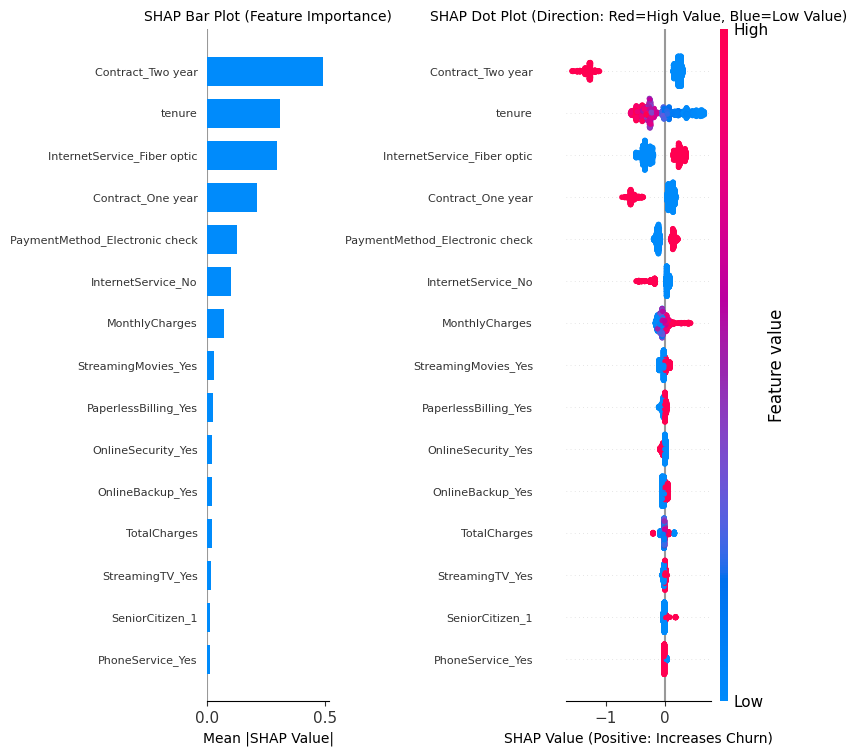

In [80]:
fig = plot_shap(shap_values, X_test)

With SHAP analysis, contract_Two years, tenure, and contrac_One year have highest negative shap value, indicating negative influence to churn rate. while internetService_fiber optic, and PaymentMethod_Electronic check have both positive shap value, indicating positive influence to churn rate.